# Lasso Regression

Lasso Regression (Least Absolute Shrinkage and Selection Operator) is a variant of linear regression that adds an **L1 penalty** to the loss function. This penalty both constrains the coefficients and can **set some of them exactly to zero**, performing automatic feature selection.

### Why Constrain the Weights?

In ordinary linear regression, coefficients can become very large in the presence of multicollinearity or high-dimensional data, leading to:

- Overfitting (capturing noise rather than signal)  
- High variance (small changes in the data cause large changes in coefficients)  
- Poor generalization to unseen data

**L1 regularization (Lasso)** not only shrinks coefficients but also can eliminate irrelevant features, producing a **sparser and more interpretable model**.

### Lasso Regression Objective Function

The cost function minimized by Lasso Regression is:

$$
\min_{\beta} \left\{ 
\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} x_{ij} \beta_j \right)^2
+ 
\lambda \sum_{j=1}^{p} |\beta_j|
\right\}
$$

Where:
- $\beta_j$ are the model coefficients  
- $\lambda \ge 0$ is the regularization strength  
- The term $\sum_{j=1}^{p} |\beta_j|$ is the **L1 penalty**

**Effect:**  
🔹 Coefficients are shrunk, and some are set exactly to zero  
🔹 This allows the model to **perform feature selection** automatically

### Why Lasso Can Eliminate Variables (Unlike Ridge)

- **L1 norm** has sharp corners at zero, making it likely that the optimization solution lies exactly on an axis.  
- **Ridge (L2 norm)** is smooth, shrinking coefficients continuously but never exactly to zero.  

**Conclusion:**  
Lasso is useful when we want a **sparse model** with fewer features, improving interpretability and reducing overfitting.


## 1. Data Generation

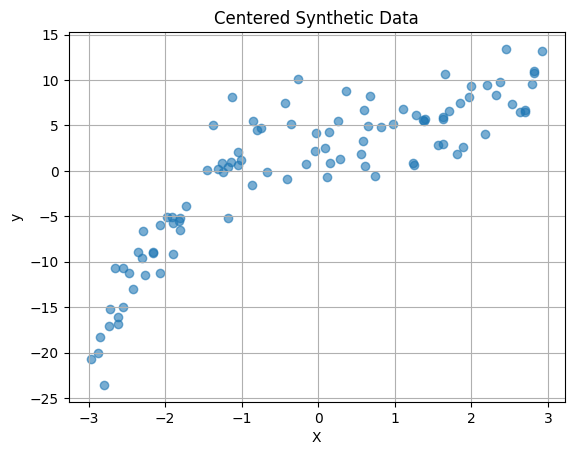

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# X data within [-3, 3], centered around 0
n_samples = 100
X = np.sort(np.random.rand(n_samples, 1) * 6 - 3, axis=0)

# Target y also centered around 0
y = 0.5 * X**3 - X**2 + X + np.random.randn(n_samples, 1) * 3
y = y - y.mean()  # centering

plt.scatter(X, y, alpha=0.6)
plt.title("Centered Synthetic Data")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.show()


## 2. Direct creation of standardized polynomial features

We build the powers of X and center/scale each column during generation

In [2]:
def polynomial_features_standardized(X, degree):
    X_poly = np.ones((X.shape[0], degree + 1))
    means = []
    stds = []

    for d in range(1, degree + 1):
        col = X[:, 0] ** d
        col_centered = col - np.mean(col)
        col_std = np.std(col_centered)
        col_scaled = col_centered / (col_std if col_std != 0 else 1)

        X_poly[:, d] = col_scaled
        means.append(np.mean(col))
        stds.append(np.std(col_centered))

    return X_poly, means, stds


In [3]:
degree = 8
X_scaled, _, _ = polynomial_features_standardized(X, degree)

### Implementation of Coordinate Descent for Lasso

Each coefficient is updated according to:

$$
\beta_j \leftarrow S\Bigg(\frac{1}{n} \sum_{i=1}^{n} x_{ij} \Big(y_i - \sum_{k \neq j} x_{ik} \beta_k \Big), \frac{\lambda}{2}\Bigg)
$$

where $S$ is the **soft-thresholding function**:

$$
S(z, \gamma) = \text{sign}(z) \cdot \max(|z| - \gamma, 0)
$$

This update is applied iteratively to each coefficient until convergence.


In [4]:
def soft_thresholding(z, alpha):
    if z > alpha:
        return z - alpha
    elif z < -alpha:
        return z + alpha
    else:
        return 0.0

In [5]:
def soft_thresholding(z, alpha):
    if z > alpha:
        return z - alpha
    elif z < -alpha:
        return z + alpha
    else:
        return 0.0

In [6]:
def lasso_coordinate_descent(X, y, alpha, max_iter=1000, tol=1e-4):
    n_samples, n_features = X.shape
    theta = np.zeros(n_features)

    for iteration in range(max_iter):
        theta_old = theta.copy()

        for j in range(n_features):
            y_pred = X @ theta
            r_j = y - y_pred + theta[j] * X[:, j]
            rho = np.dot(X[:, j], r_j)
            theta[j] = soft_thresholding(rho / n_samples, alpha)

        if np.linalg.norm(theta - theta_old, ord=1) < tol:
            break

    return theta

### Visualisation L1 effect

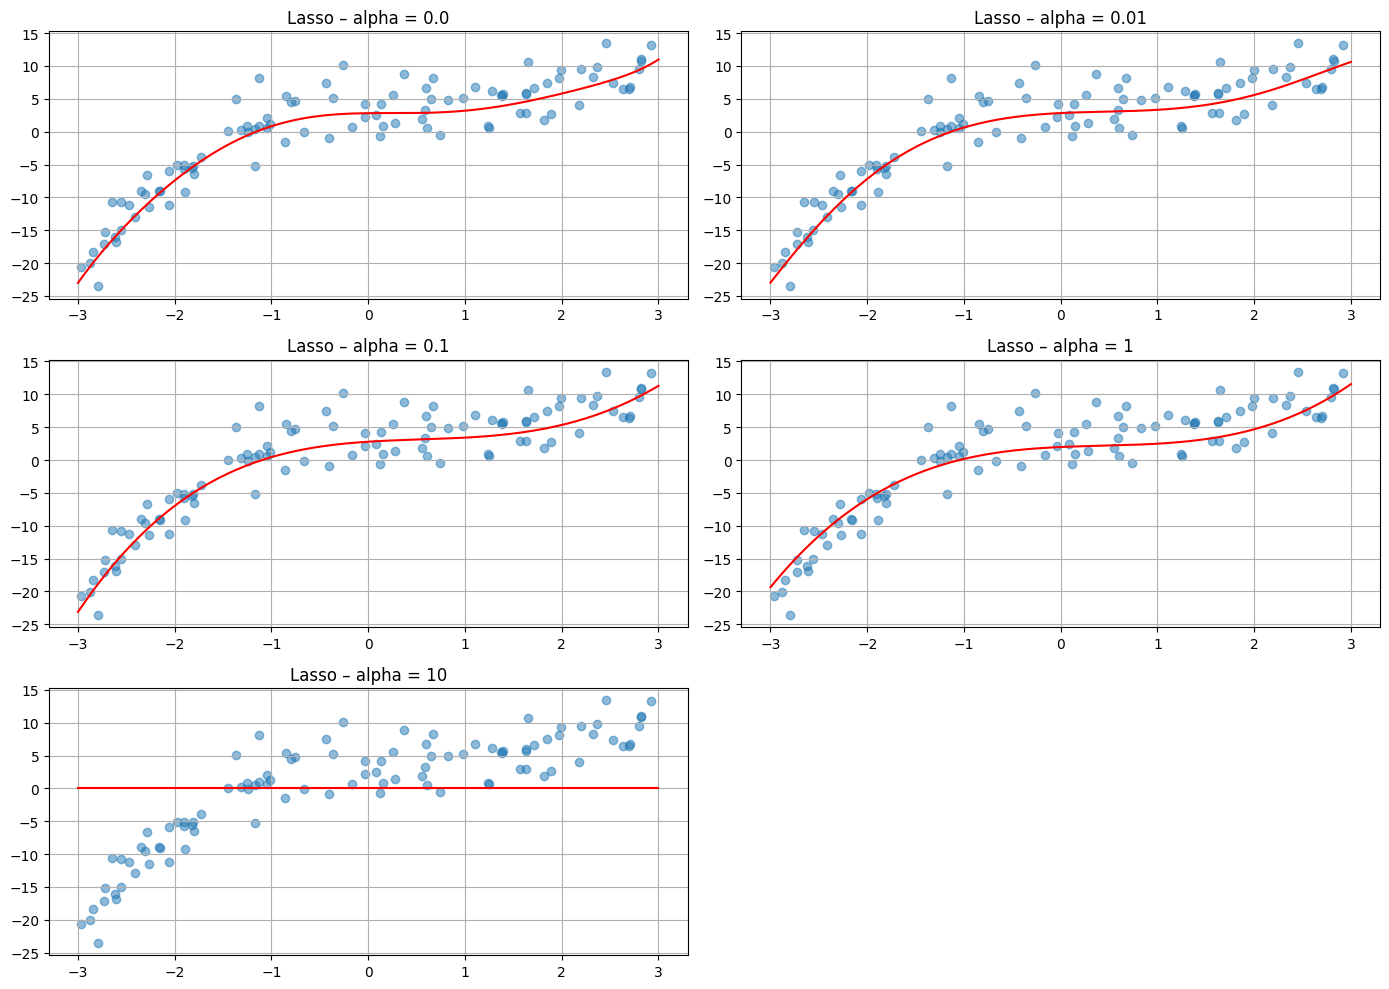

In [7]:
X_plot = np.linspace(-3, 3, 200).reshape(-1, 1)
X_plot_scaled, _, _ = polynomial_features_standardized(X_plot, degree)

alphas = [0.0, 0.01, 0.1, 1, 10]

plt.figure(figsize=(14, 10))
for i, alpha in enumerate(alphas, 1):
    theta = lasso_coordinate_descent(X_scaled, y.ravel(), alpha)
    y_pred = X_plot_scaled @ theta

    plt.subplot(3, 2, i)
    plt.scatter(X, y, alpha=0.5)
    plt.plot(X_plot, y_pred, color='red')
    plt.title(f"Lasso – alpha = {alpha}")
    plt.grid(True)

plt.tight_layout()
plt.show()

### What Do We Observe?

When the regularization parameter $\alpha$ is very large, Lasso sets all coefficients to zero to minimize the penalty cost. This effectively ignores all variables: the model then predicts a constant (often 0 if the data are centered), illustrated by a horizontal line, as seen in the last plot.

### Conclusion: What Lasso Enables

- Lasso applies an **L1 penalty** that can push some coefficients exactly to zero.  
- This allows **automatic feature selection**, keeping only the most relevant variables.

By increasing the `alpha` parameter:

- The model complexity is reduced  
- Overfitting is avoided  
- However, predictive accuracy may decrease if regularization is too strong

**Additional Notes:**  
Coordinate descent is particularly well-suited for solving this problem.  
Here, the data are centered, and features are standardized as they are created, which avoids common pitfalls such as division by zero.


---

## Lasso Regression with Scikit-learn

### Important Parameters of Lasso

- **alpha** *(float, default=1.0)*  
  Regularization strength (L1 penalty).  
  Higher values strongly shrink coefficients, potentially setting some to zero, which encourages feature selection.

- **fit_intercept** *(bool, default=True)*  
  If True, the model estimates an intercept (bias term).  
  If False, the data should be centered.

- **max_iter** *(int, default=1000)*  
  Maximum number of iterations for the algorithm to converge.

- **tol** *(float, default=1e-4)*  
  Convergence tolerance. Reduce for higher precision, but it may slow down computation.


### alpha parameter variation

In [8]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("-", "--", ":")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 3 if alpha > 0 else 2
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.scatter(X, y, color='k', linewidth=2)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

/home/cruchau/projects/github_input/machine_learning/linear_model/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


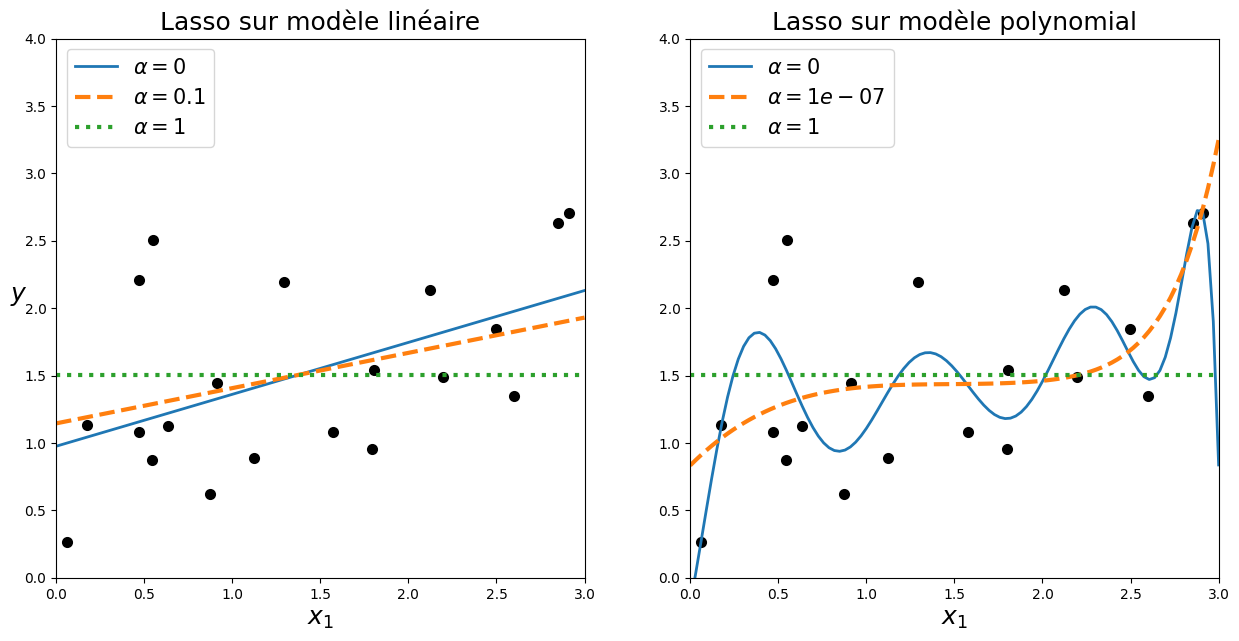

In [9]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.title("Lasso sur modèle linéaire", fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)
plt.title("Lasso sur modèle polynomial", fontsize=18)
plt.show()

### What Do We Observe?

- **Small alpha (0.1):**  
  The model retains most coefficients, close to those of ordinary linear regression. Model complexity is not significantly reduced.

- **Intermediate alpha (1):**  
  Several coefficients are shrunk to zero, performing automatic selection of the most relevant features.

- **Large alpha (10 and 40):**  
  Many variables are eliminated, the model becomes very simple, but may be underfitted.

**Conclusion:**  
Lasso is particularly useful for quickly identifying important features while simplifying the model by removing less significant ones.


## LassoCV: Internal Cross-Validation for Automatic Alpha Selection

`LassoCV` automatically selects the optimal `alpha` using internal cross-validation.

### Key Additional Parameters

- **eps**: Ratio between the smallest and largest alpha to test.  
- **n_alphas**: Number of alpha values tested automatically.  
- **cv**: Cross-validation strategy (default: 5-fold).


In [22]:
from sklearn.datasets import make_regression

np.random.seed(0)
X, y = make_regression(n_samples=100, n_features=18, noise=10.0, random_state=42)

Best alpha selected: 0.1942


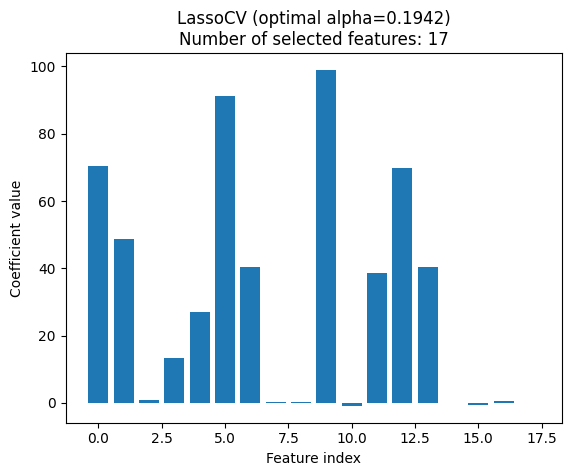

In [23]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# Fit Lasso with internal 5-fold cross-validation to select the best alpha
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X, y)

print(f"Best alpha selected: {lasso_cv.alpha_:.4f}")

# Plot the coefficients
plt.bar(range(len(lasso_cv.coef_)), lasso_cv.coef_)
plt.title(f'LassoCV (optimal alpha={lasso_cv.alpha_:.4f})\nNumber of selected features: {(lasso_cv.coef_ != 0).sum()}')
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.show()


### What Do We Observe with LassoCV?

`LassoCV` automatically selects the optimal alpha to balance **accuracy** and **sparsity**.  
This results in a model that performs well while maintaining minimal complexity, automatically eliminating unnecessary features.

**Conclusion:**  
In practice, `LassoCV` is particularly useful when the goal is to obtain a **simple and interpretable model** without manually tuning the regularization parameter.
